In [45]:
import pvdeg
from pvdeg.geospatial import output_template
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pandas as pd
import xarray as xr
import dask.array as da
import pickle

from dask.distributed import LocalCluster, Client

In [4]:
# geospatial scenario with downsample factor 120
tiny_res = xr.open_dataset("tiny-pysam-ground-irradiance.nc", engine='h5netcdf')

tiny_res

In [13]:
tiny_res

<xarray.Dataset> Size: 14MB
Dimensions:            (latitude: 2, longitude: 5, time: 17520, distance: 10)
Coordinates:
  * latitude           (latitude) float32 8B 31.33 40.93
  * longitude          (longitude) float32 20B -115.9 -106.3 ... -87.14 -77.54
  * time               (time) datetime64[ns] 140kB 2022-01-01 ... 2022-12-31T...
  * distance           (distance) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    ground_irradiance  (time, distance, latitude, longitude) float64 14MB ...
    annual_poa         (latitude, longitude) float64 80B ...

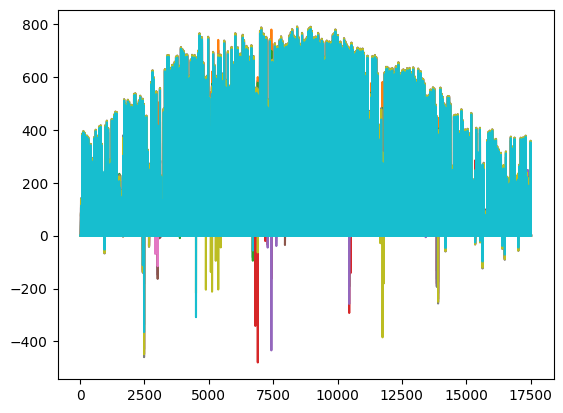

In [10]:
plt.plot(tiny_res.isel(latitude=0, longitude=2).ground_irradiance)

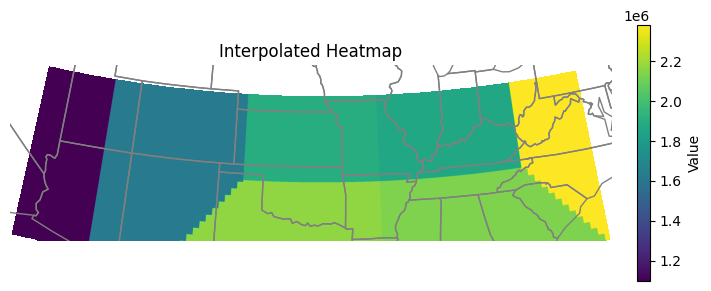

In [14]:
pvdeg.geospatial.plot_sparse_analysis(tiny_res, 'annual_poa', 'nearest')

In [15]:
# geospatial scenarion with downsample factor 80
# this fails to capture a lot of information still, it is only 23 points
medium_res = xr.open_dataset("medium-pysam-ground-irradiance.nc", engine='h5netcdf')

medium_res

<xarray.Dataset> Size: 45MB
Dimensions:            (latitude: 4, longitude: 8, time: 17520, distance: 10)
Coordinates:
  * latitude           (latitude) float32 16B 28.13 34.53 40.93 47.33
  * longitude          (longitude) float32 32B -119.1 -112.7 ... -80.74 -74.34
  * time               (time) datetime64[ns] 140kB 2022-01-01 ... 2022-12-31T...
  * distance           (distance) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    ground_irradiance  (time, distance, latitude, longitude) float64 45MB ...
    annual_poa         (latitude, longitude) float64 256B ...

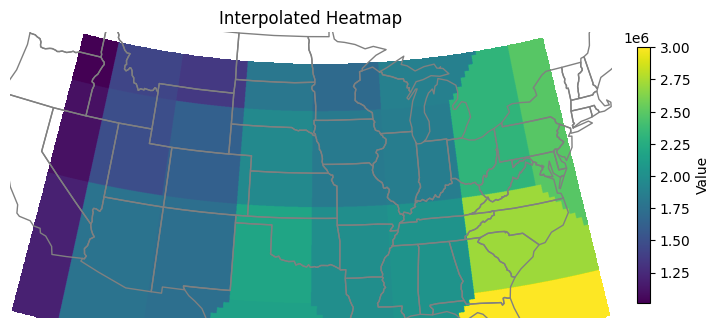

In [19]:
pvdeg.geospatial.plot_sparse_analysis(medium_res, 'annual_poa', 'nearest')

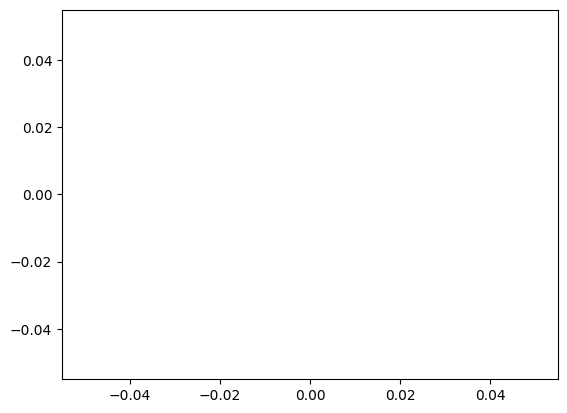

In [24]:
plt.plot(medium_res.isel(latitude=0, longitude=0)["ground_irradiance"])

In [16]:
nonzero_mask = (medium_res["ground_irradiance"] != 0).any(dim="distance")

filtered_data = medium_res["ground_irradiance"].where(nonzero_mask, drop=True)

monthly_avg_ground_irradiance = filtered_data.groupby(filtered_data.time.dt.month).mean()



In [39]:
print(monthly_avg_ground_irradiance)

<xarray.DataArray 'ground_irradiance' (month: 12, distance: 10, latitude: 4,
                                       longitude: 8)> Size: 31kB
array([[[[         nan,          nan,          nan, ...,          nan,
          251.39039332,          nan],
         [ 58.11468011, 135.50811653, 130.04334361, ..., 133.85232808,
          181.60070609,          nan],
         [ 24.4110864 ,  33.46128267,  51.87048449, ...,  90.97590087,
          107.67174537, 131.8752547 ],
         [  8.26424536,  22.79696518,  19.23474817, ...,  24.92301527,
                   nan,          nan]],

        [[         nan,          nan,          nan, ...,          nan,
          103.76320269,          nan],
         [ 55.77057148, 115.69480471, 112.8438219 , ...,  99.32727088,
          120.38113996,          nan],
         [ 22.53734324,  31.22800764,  51.19419846, ...,  86.67066136,
           96.55777299, 120.14957928],
         [  7.38388653,  22.51238988,  18.32837128, ...,  21.68954543,
               

In [40]:
ground_irradiance_4th_index = monthly_avg_ground_irradiance.sel(distance=4)

In [42]:
print(ground_irradiance_4th_index)

<xarray.DataArray 'ground_irradiance' (month: 12, latitude: 4, longitude: 8)> Size: 3kB
array([[[         nan,          nan,          nan,  55.55454222,
                  nan,          nan,  54.30759401,          nan],
        [ 35.66458307,  40.59103488,  40.46357   ,  44.17483044,
          38.23314725,  45.83745845,  47.71876003,          nan],
        [ 39.04732841,  59.41248872,  51.33722895,  45.81060321,
          44.22284708,  47.42881641,  63.82298453,  56.19135839],
        [ 18.42538431,  31.28036718,  32.88908583,  47.30613005,
          47.39860878,  39.10015323,          nan,          nan]],

       [[         nan,          nan,          nan, 104.8980246 ,
                  nan,          nan, 155.29302898,          nan],
        [ 36.79962246,  41.09304574,  45.26533339,  66.73025286,
          49.57519075,  53.01782325,  67.4399442 ,          nan],
        [ 53.60133553,  60.33875813,  55.05855703,  48.44754639,
          58.31600858,  59.08787611,  67.57435107,  54.7163

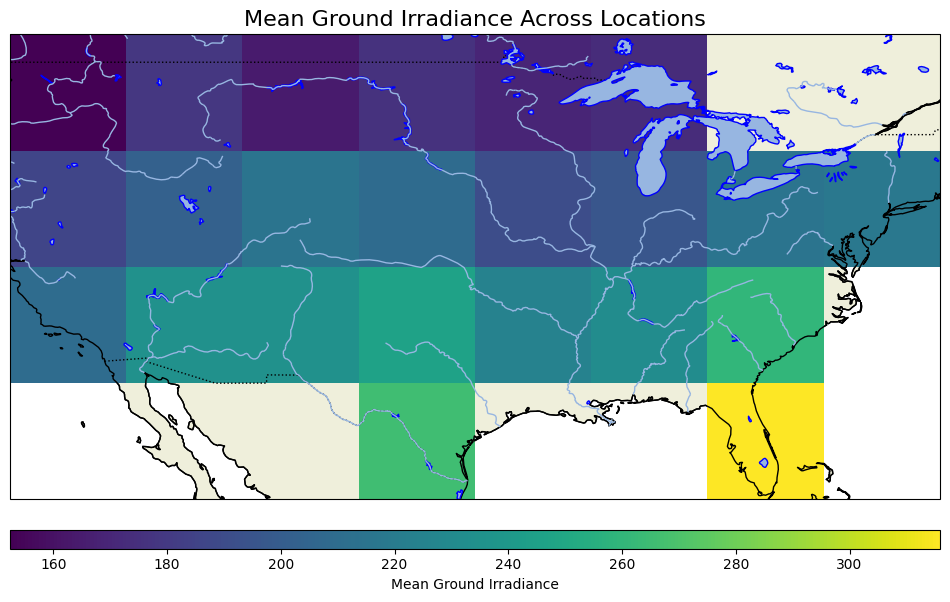

In [46]:
ground_irradiance = ground_irradiance_4th_index

mean_irradiance = ground_irradiance.mean(dim="month")

# Create the map
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))

# Plot data
mesh = ax.pcolormesh(
    mean_irradiance.longitude,
    mean_irradiance.latitude,
    mean_irradiance,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    shading="auto"
)

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='blue')
ax.add_feature(cfeature.RIVERS)

# Add colorbar
cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.05, aspect=50)
cbar.set_label("Mean Ground Irradiance")

# Add title
plt.title("Mean Ground Irradiance Across Locations", fontsize=16)

# Show the plot
plt.show()